In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np
from tensorflow import keras
from oodeel.models.load_utils import get_model
from oodeel.methods.mls import MLS
from oodeel.methods.dknn import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt

from oodeel.datasets.load import dataset_load
from oodeel.eval.metrics import bench_metrics, curve


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data and model loading
ID data: MNIST, OOD data: Fashion MNIST

In [4]:
num_classes = 10
input_shape = (28, 28, 1)

#### MNIST
# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = dataset_load("mnist")
y_train = tf.keras.utils.to_categorical(y_train, np.max(y_train) + 1)
y_test = tf.keras.utils.to_categorical(y_test, np.max(y_test) + 1)
#### Fashion MNIST

# Load the data and split it between train and test sets
_ , (x_ood, y_ood) = dataset_load("fashion_mnist")
y_ood = tf.keras.utils.to_categorical(y_ood, np.max(y_ood) + 1)




In [5]:
model = get_model("../saved_models/mnist_model")


2022-08-30 10:18:50.058036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-30 10:18:50.058103: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-30 10:18:50.058128: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (B20212474): /proc/driver/nvidia/version does not exist
2022-08-30 10:18:50.059731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Maximum Logit Score
(A good classifier is all you need ?)

Example of method that does not need ID data to compute statistics to compare against

In [16]:

%autoreload 2
oodmodel = MLS(model)
scores_id = oodmodel.score(x_test)
scores_ood = oodmodel.score(x_ood)

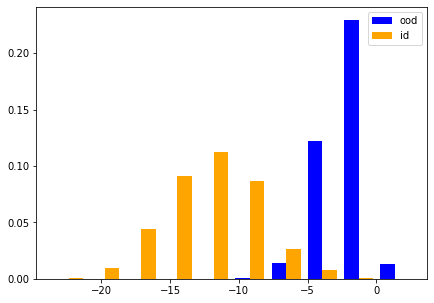

In [17]:
plt.figure(figsize=(7,5))

plt.hist((scores_ood, scores_id), bins=10, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()

Sanity check to test the `__call__` method

In [14]:
oodmodel.threshold = -5
isooddata = oodmodel.isood(inputs=x_ood)
isooddata2 = oodmodel(x_ood)
print(np.sum(isooddata - isooddata2))
print(np.sum(isooddata)/x_ood.shape[0])

0.0
0.949


0.9947957849999999


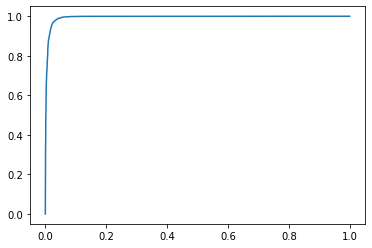

In [18]:
%autoreload 2
scores = np.concatenate([scores_id, scores_ood]) #ood has to be higher
labels = np.concatenate([np.zeros(scores_id.shape), np.ones(scores_ood.shape)])

tpc, fpc, tnc, fnc = curve(scores, labels)
tpr = np.concatenate([[1.], tpc/(tpc + fnc), [0.]])
fpr = np.concatenate([[1.], fpc/(fpc + tnc), [0.]])
(auroc), _ = bench_metrics(scores, labels)

print(auroc)
plt.plot(fpr, tpr)
plt.show()

## Deep KNN
Example of method that needs ID data to compute statistics to compare against

In [20]:
%autoreload 2
oodmodel = DKNN(model)
oodmodel.fit(x_train[:10000])

In [21]:
scores_id = oodmodel.score(x_test[:1000])
scores_ood = oodmodel.score(x_ood[:1000])

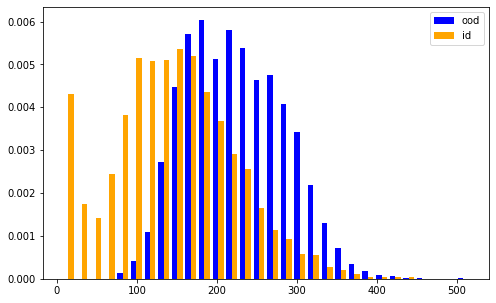

In [22]:
plt.figure(figsize=(8,5))

plt.hist((scores_ood, scores_id), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.7932586


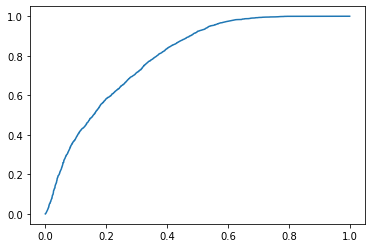

In [23]:
%load_ext autoreload
%autoreload 2

scores = np.concatenate([scores_id, scores_ood]) #ood has to be higher
labels = np.concatenate([np.zeros(scores_id.shape), np.ones(scores_ood.shape)])

tpc, fpc, tnc, fnc = curve(scores, labels)
tpr = np.concatenate([[1.], tpc/(tpc + fnc), [0.]])
fpr = np.concatenate([[1.], fpc/(fpc + tnc), [0.]])
(auroc), _ = bench_metrics(scores, labels)

print(auroc)
plt.plot(fpr, tpr)
plt.show()